<h1> <big> Breast cancer diagnosis prediction: a case study for feature selection </big> </h1> 
<p> <big>Breast Cancer Wisconsin (Diagnostic) Data Set - Kaggle </big></p> 
<h3> Vera Giulia Sala - Ubiqum Code Academy </h3>


<ol> 
  <li><a href="#p1"> Goal of the analysis</a></li> 
  <li><a href="#p2">Dataset</a></li> 
  <li><a href="#p3">Preprocessing and explorative analysis of data</a></li> 
  <li><a href="#p4">Feature selection</a></li> 
      <ol>   <li> <a href="#p4_1">Elimination highly collinear features</a> </li> 
             <li> <a href="#p4_2">Univariate feature selection – (ANOVA, d-cohen)</a> </li>
             <li> <a href="#p4_3">Logistic regression with Lasso penalization</a> </li>
             <li> <a href="#p4_4">Random forest, feature importance</a> </li>
             <li> <a href="#p4_5">Recursive feature elimination (RFE)</a> </li></ol>
  <li><a href="#p5">Comparison predictive models with different feature selection</a></li> 
  <li><a href="#p6">Principal Component Analysis</a></li> 
  <li><a href="#p7">Conclusion</a></li> 
</ol>


# <a id="p1">Goal of the analysis</a> 

The goal of the analysis is to predict whether a breast cancer is benign or malignant depending on the characteristics of the cancer cell nuclei exctracted from digitized images of a fine needle aspirate (FNA) of a breast mass.  
The analysis has been focused on feature selection, with the main objective of determining which nuclei features are more relevant for diagnosis predictions.


# <a id="p2">Dataset</a>

**Data set**        
569 instances,  30 features 


**Features**  
The features are computed from a digitized image of a fine needle aspirate (FNA) 
of a breast mass and they describe the characteristics of the cell nuclei.  

- radius (mean of distances from centre to points on the perimeter) 
- texture (standard deviation of gray-scale values) 
- perimeter 
- area 
- smoothness (local variation in radius lengths) 
- compactness (perimeter^2 / area - 1.0) 
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry 
- fractal dimension ("coastline approximation" - 1)

3 values for each feature: mean, standard error and worst (largest) value


# <a id="p3">Preprocessing and explorative analysis of data</a>

We perform an explorative analysis of data, and we standardize all the features.

In [154]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from biokit.viz import corrplot
from collections import OrderedDict
from sklearn import preprocessing as pp
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split


In [3]:
dati=pd.read_csv("data.csv")


In [4]:
dati.shape

(569, 33)

In [5]:
dati.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
pd.value_counts(dati['diagnosis'])

B    357
M    212
Name: diagnosis, dtype: int64

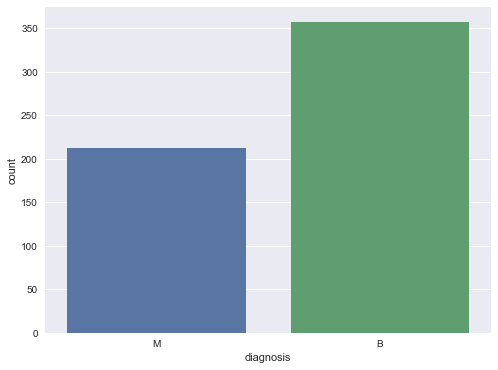

In [7]:
fig = plt.figure(1, figsize=(8, 6))
sns.countplot(x = 'diagnosis', data = dati)
plt.show()
fig.savefig("class_distr.png")

Populating the interactive namespace from numpy and matplotlib


C:\Users\A\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['xlim', 'colors', 'legend', 'copy', 'ylim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


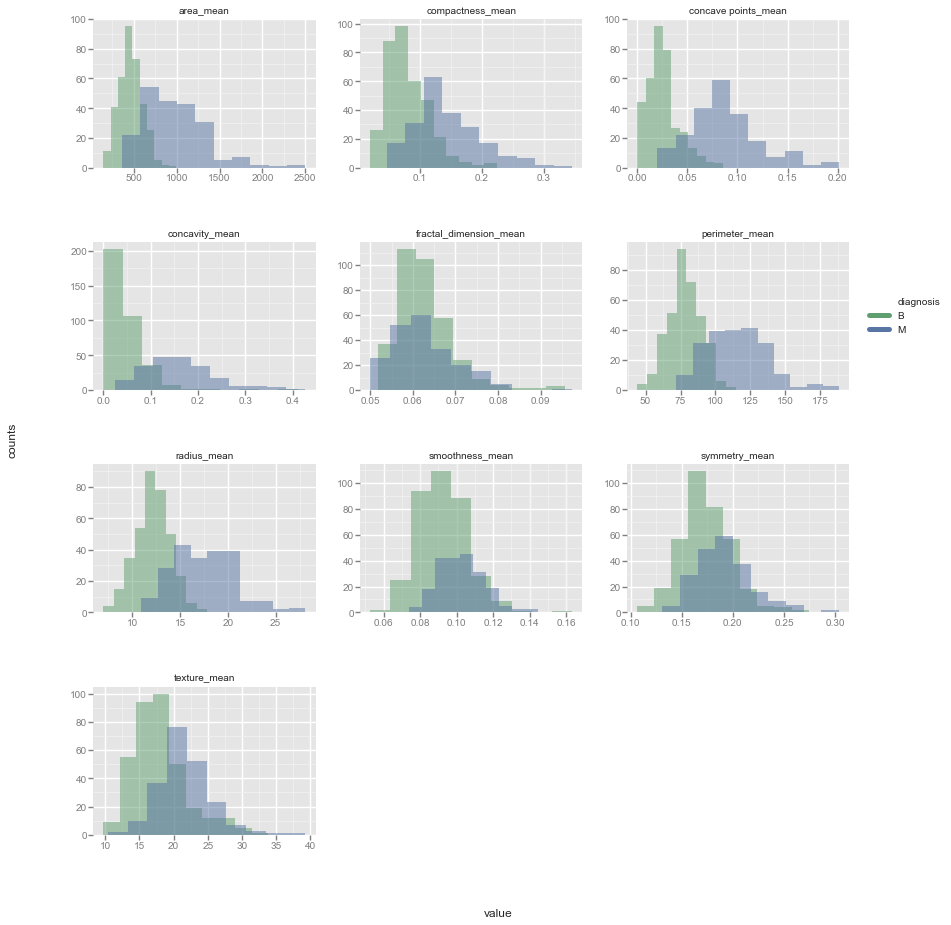

In [155]:
%pylab inline
dati_melted = pd.melt(dati.iloc[:,1:12], id_vars=['diagnosis'])
lab_new = ["Mean Area", "Mean Compactness", "Mean Concave Points", "Mean Concavity","Mean Fractal Dimension","Mean Perimeter","Mean Radius", "Mean Smoothness","Mean Symmetry","Mean Texture"]
aaa=ggplot(dati_melted, aes(x='value', fill='diagnosis')) +\
     geom_histogram(alpha=0.5)+ facet_wrap("variable",scales="free")+\
     labs( x = 'value', y = 'counts')+ scale_fill_manual(values=("#5F9E6F","#5975A4" ))
aaa.save("bm.pdf", width=15, height=15) 


**Standardize data**

In [9]:
dati_scaled = pd.DataFrame(pp.scale(dati.iloc[:,2:32]))

In [10]:
repl = dict( zip( list(dati_scaled.columns.values), list((dati.columns.values[2:32]))))
dati_scaled= dati_scaled.rename(columns=repl)
dati_scaled["diagnosis"] = dati.diagnosis

In [11]:
datiii = dati_scaled.iloc[:,0:10]
datiii = pd.concat([datiii,dati_scaled.diagnosis],axis=1)

(array([-6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 <a list of 8 Text xticklabel objects>)

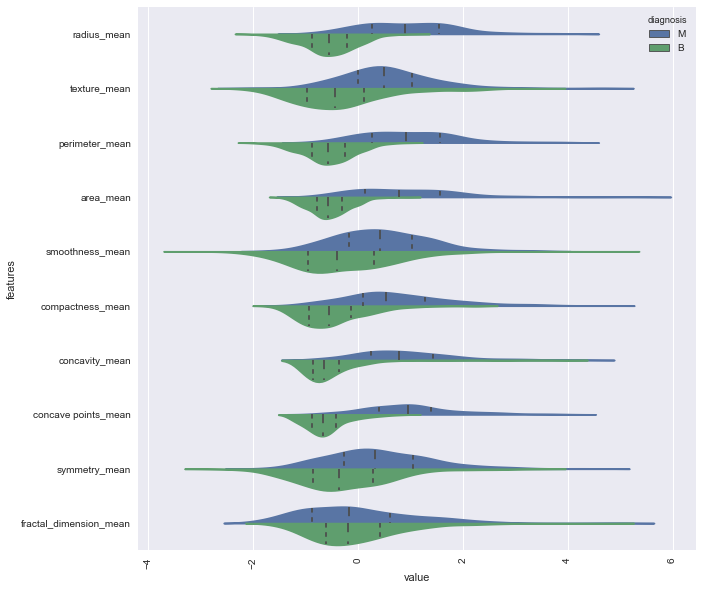

In [12]:
datax = pd.melt(datiii,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(y="features", x="value", hue="diagnosis", data=datax,split=True, inner="quart")
plt.xticks(rotation=90)

# <a id="p4">Feature selection</a>

The main goal of the analysis is to determine which features are more relevant for diagnosis prediction.   
After removing highly collinear features, we try and compare different feature selection methods.  

## <a id="p4_1">Elimination highly collinear features</a>

Highly collinear features increase the dimensionality of the problem, without adding valuable information. A clear example is given by the variables: "radius", "perimeter", "area" that are related by a clear functional dependance. We eliminate the highly collinear features (where Pearson correlation coefficient is > 0.85), keeping only the one that has the highest correlation with the dependent variable. 

C:\Users\A\Anaconda3\lib\site-packages\biokit\viz\linkage.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = hierarchy.linkage(D, method=method, metric=metric)


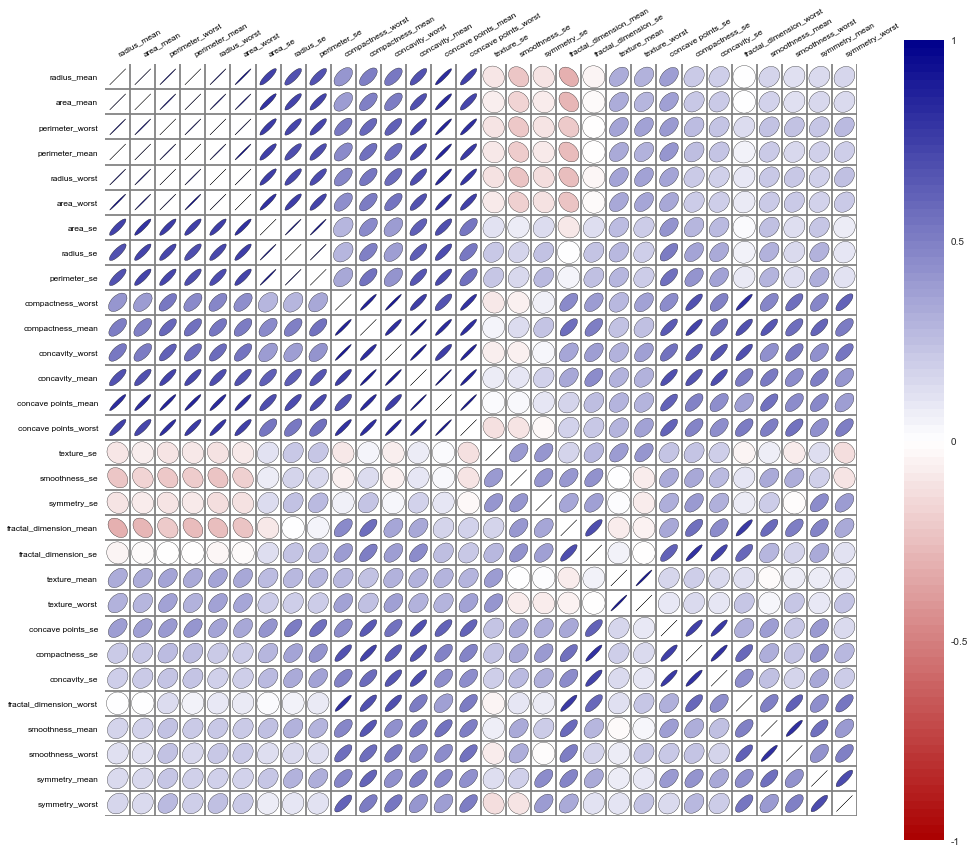

In [13]:
yyy=plt.figure(figsize=(15, 15))
corr2 = dati_scaled.corr()

c2 = corrplot.Corrplot(corr2)
c2.plot(fig=yyy)

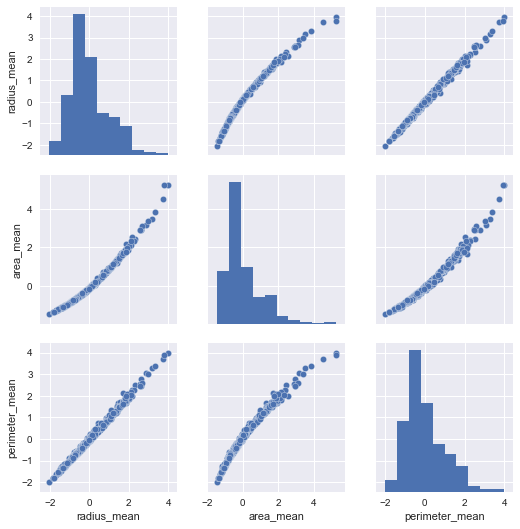

In [14]:
rrr = dati_scaled.loc[:,["radius_mean","area_mean","perimeter_mean"]]
g = sns.PairGrid(rrr,diag_sharey=False)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, edgecolor="w", s=40)
plt.rcParams["axes.labelsize"] = 15
plt.rcParams['figure.figsize'] = 10, 10
plt.show()

In [15]:
elimin = ["radius_worst", "area_mean", "area_worst", "perimeter_mean", "perimeter_worst",  "perimeter_se", "area_se",
          "texture_worst","concave points_mean", "concave points_worst", "concavity_worst", "compactness_worst"]
dati_red = dati_scaled.drop(elimin, axis=1)

In [16]:
dati_red.shape

(569, 19)

## <a id="p4_2">Univariate feature selection – (ANOVA, d-cohen)</a>

Univariate feature selection is done by calculating the correlation of each independent variable separately with the dependent variable, and keeping the features with the highest correlation coefficient. To measure univariate correlation we use ANOVA and d-Cohen cefficient as effect size. 

$$Cohen's \hspace{1 mm} d = \frac{\bar{X_{1}}-\bar{X_{2}}}{\sqrt{S_{p}^{2}}}$$

In [ ]:
from sklearn.feature_selection import f_classif

In [17]:
X=dati_red[dati_red.columns[dati_red.columns != "diagnosis" ]]
y=dati_red["diagnosis"]

In [18]:
anova_corr = pd.DataFrame((f_classif(X, y))[0])
anova_corr= anova_corr.rename(columns={0: "F-value"})
anova_corr["p-value"] =(f_classif(X, y))[1]
anova_corr["variable"] = X.columns

In [19]:
malign = X[(y == "M")]
bening =  X[(y == "B")]
m_std = malign.apply(np.std, 0)
b_std = bening.apply(np.std, 0)
m_mean = malign.apply(np.mean, 0)
b_mean = bening.apply(np.mean, 0)
df_m = malign.shape[0]-1
df_b = bening.shape[0]-1
sp_sq = (m_std**2*df_m + b_std**2*df_b)/(df_m+df_b)
d_cohen =  abs(m_mean - b_mean)/np.sqrt(sp_sq)
anova_corr["d_cohen"] = np.array(d_cohen)

In [20]:
anova_corr.sort_values("d_cohen",ascending=False).iloc[0:5,:]

,F-value,p-value,variable,d_cohen
0,646.981021,8.465941e-96,radius_mean,2.209955
4,533.793126,9.966556e-84,concavity_mean,2.007319
3,313.233079,3.938263e-56,compactness_mean,1.537618
7,268.840327,9.738949e-50,radius_se,1.424834
15,122.472880,6.575144e-26,smoothness_worst,0.961294


> **The 5 most relevant features are: radius_mean, concavity_mean, compactness_mean, radius_se, smoothness_worst**

## <a id="p4_3">Logistic regression with Lasso penalization</a>

Logistic regression with Lasso penalization fits the training data minimizing the cost function:

$min_{\theta}\frac{1}{2}\Sigma(y_{i}-X_{i}\theta)^{2}+\lambda \vert\theta \vert_{1} $

For a value for the $\lambda$ coefficient high enough, some feature coefficients go to zero. So a feature selection is performed. For all the remaining feature a further selection can be done by considering the magnitude of the coefficients.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [21]:
log_reg_cv = linear_model.LogisticRegressionCV(Cs=10,cv=5,random_state=123,penalty="l1",solver="liblinear")
regr = log_reg_cv.fit(X.as_matrix(),np.squeeze(np.asarray(y.as_matrix())))

lasso regression for 10 values of lambda (cv = 5): best value is 3.59381366e-01

In [22]:
regr.Cs_

array([  1.00000000e-04,   7.74263683e-04,   5.99484250e-03,
         4.64158883e-02,   3.59381366e-01,   2.78255940e+00,
         2.15443469e+01,   1.66810054e+02,   1.29154967e+03,
         1.00000000e+04])

In [23]:
pd.DataFrame(regr.scores_["M"])

,0,1,2,3,4,5,6,7,8,9
0,0.626087,0.626087,0.626087,0.904348,0.947826,0.973913,0.965217,0.956522,0.956522,0.956522
1,0.626087,0.626087,0.626087,0.956522,0.956522,0.939130,0.947826,0.947826,0.939130,0.939130
2,0.628319,0.628319,0.628319,0.973451,0.973451,0.955752,0.946903,0.946903,0.946903,0.946903
3,0.628319,0.628319,0.628319,0.973451,0.982301,0.973451,0.973451,0.973451,0.973451,0.973451
4,0.628319,0.628319,0.628319,0.955752,0.964602,0.982301,0.973451,0.973451,0.973451,0.973451


In [24]:
(np.mean(pd.DataFrame((regr.scores_["M"]))))

0    0.627426
1    0.627426
2    0.627426
3    0.952705
4    0.964940
5    0.964910
6    0.961370
7    0.959631
8    0.957891
9    0.957891
dtype: float64

In [25]:
dict4 =dict(zip((X.columns ), (np.squeeze(regr.coef_))))
feature_regr = np.transpose(pd.DataFrame([dict4]))
feature_regr.columns = ["Regr_coeff"]
np.abs(feature_regr).sort_values("Regr_coeff",ascending=False)

,Regr_coeff
radius_mean,2.907901
radius_se,1.764286
concavity_mean,1.613836
smoothness_worst,1.075027
texture_mean,1.065012
symmetry_worst,1.053832
symmetry_se,0.573840
fractal_dimension_se,0.489557
compactness_se,0.170258
fractal_dimension_mean,0.018919


> **The 5 most relevant features are: radius_mean, radius_se, concavity_mean, smoothness_worst, texture_mean**

## <a id="p4_4">Random forest, feature importance</a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rs = ShuffleSplit(n_splits=10, test_size=0.2, random_state=120)

X1= X.copy()
Y1= y.copy()
rf = RandomForestClassifier()

risRF = pd.DataFrame(np.array(range(18)))
accurac = []
i=0

for train_index, test_index in rs.split(X1):
    i=i+1
    #print("TRAIN:", train_index, "TEST:", test_index)
    XX_train, XX_test = X1.iloc[train_index,:], X1.iloc[test_index,:]
    YY_train, YY_test = Y1.iloc[train_index], Y1.iloc[test_index]
    r = rf.fit(XX_train, (np.array(YY_train)))
    aaa = accuracy_score(YY_test,r.predict(XX_test))
    ddff = pd.DataFrame(np.squeeze(r.feature_importances_))
    ddff.columns = [str(i)]
    accurac.append(aaa)
    risRF = risRF.join(ddff, lsuffix='_caller', rsuffix='_other')


In [27]:
mean(accurac)


0.93245614035087721

In [28]:
risRF["feature"] = np.squeeze(X.columns)
risRF["mean_importance"] = risRF.iloc[:,1:6].mean(1)
a1= risRF.sort_values("mean_importance",ascending=False)
a1.index = np.array(range(18))
a1

,0,1,2,3,4,5,6,7,8,9,10,feature,mean_importance
0,0,0.296027,0.209256,0.279639,0.250597,0.315955,0.266197,0.176660,0.256648,0.146746,0.300093,radius_mean,0.270295
1,4,0.205814,0.176411,0.120029,0.192132,0.090976,0.263117,0.302028,0.241315,0.258859,0.133092,concavity_mean,0.157072
2,7,0.034642,0.106698,0.077617,0.119739,0.123857,0.058835,0.054964,0.079569,0.077562,0.116442,radius_se,0.092511
3,3,0.050054,0.102833,0.095233,0.064996,0.076856,0.100203,0.116617,0.034585,0.127331,0.116226,compactness_mean,0.077994
4,11,0.044922,0.058753,0.059516,0.072004,0.062186,0.020760,0.010121,0.093431,0.046816,0.051594,concavity_se,0.059476
5,1,0.060648,0.020133,0.062514,0.088576,0.040513,0.059885,0.121192,0.060505,0.081172,0.026054,texture_mean,0.054477
6,12,0.069675,0.040589,0.013604,0.029747,0.080195,0.005590,0.005941,0.013073,0.036474,0.030449,concave points_se,0.046762
7,16,0.069453,0.053201,0.043467,0.029900,0.024812,0.038875,0.046513,0.040816,0.030671,0.034061,symmetry_worst,0.044167
8,15,0.030344,0.032229,0.051715,0.012714,0.061601,0.042067,0.034408,0.017755,0.022015,0.025054,smoothness_worst,0.037721
9,6,0.015731,0.053230,0.036400,0.024726,0.008225,0.034861,0.021118,0.022221,0.029799,0.026287,fractal_dimension_mean,0.027662


> **The 5 most relevant features are: radius_mean, concavity_mean, radius_se, compactness_mean, concavity_se**

## <a id="p4_5">Recursive feature elimination (RFE)</a>

In [ ]:
from sklearn.feature_selection import RFE

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,random_state=101)

In [30]:
clf_rf_3 = DecisionTreeClassifier()
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)

In [31]:
X_train.columns[rfe.support_]

Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_worst'],
      dtype='object')

> **The 5 most relevant features are: radius_mean, texture_mean, smoothness_mean, concavity_mean, symmetry_worst**

# <a id="p5">Comparison predictive models with different feature selection</a>

We train a number of classification predictive models, using 3-fold cross - validation on the full dataset, and we compare the accuracy of prediction. We repeat the predictions using three different feature selections decided from our analysis:  
- all features
- 7 features: "radius_mean","radius_se","concavity_mean","smoothness_worst","fractal_dimension_se","texture_mean","symmetry_worst"
- 3 features: "radius_mean","radius_se","concavity_mean"

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [32]:
reg= [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), svm.SVC(), KNeighborsClassifier(n_neighbors=5), 
      MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2),random_state=123), SGDClassifier(),
     GradientBoostingClassifier(n_estimators=150), AdaBoostClassifier(n_estimators=150)]
model = ["Logistic Regression","Random Forest", "Decision Tree", "SVM", "k-nn", 
   "Neural Network","SGD","Gradient Boosting", "AdaBoost"]

performance = pd.DataFrame(model)
performance.rename(columns={0: 'Model'}, inplace=True)
performance["Accuracy 18 features"]= np.zeros(9)
performance["Accuracy 7 features"]= np.zeros(9)
performance["Accuracy 3 features"]= np.zeros(9)

s=0
for i in reg:
    acc = cross_val_score(i,X, y,cv=3)
    #print(model[s] + "   " +str(np.mean(acc)) )
    performance.iloc[s,1] = np.mean(acc)
    s=s+1

In [33]:
sel_feat = ["radius_mean","radius_se","concavity_mean","smoothness_worst","fractal_dimension_se","texture_mean","symmetry_worst"]   
X_sel= X[sel_feat]


s=0
for i in reg:
    acc = cross_val_score(i,X_sel, y,cv=3)
    #print(model[s] + "   " +str(np.mean(acc)))
    performance.iloc[s,2] = np.mean(acc)
    s=s+1
         


In [34]:
sel_feat1 = ["radius_mean","radius_se","concavity_mean"]      
X_sel1= X[sel_feat1]


s=0
for i in reg:
    acc = cross_val_score(i,X_sel1, y,cv=3)
    #print(model[s] + "   " +str(np.mean(acc)))
    performance.iloc[s,3] = np.mean(acc)
    s=s+1
         


In [35]:
performance

,Model,Accuracy 18 features,Accuracy 7 features,Accuracy 3 features
0,Logistic Regression,0.970129,0.964847,0.915678
1,Random Forest,0.940258,0.952585,0.910387
2,Decision Tree,0.922640,0.934976,0.892797
3,SVM,0.963102,0.964857,0.913924
4,k-nn,0.949021,0.949039,0.915669
5,Neural Network,0.952529,0.949002,0.913914
6,SGD,0.956029,0.927847,0.915660
7,Gradient Boosting,0.956066,0.950794,0.906897
8,AdaBoost,0.959593,0.961357,0.920932


**Train-test prediction with logistic regression**

In [165]:
clf_log_reg =LogisticRegression()      

log_reg = clf_log_reg.fit(X_train, y_train)
accuracy_score(y_test,log_reg.predict(X_test))

0.94736842105263153

> **The best prediction accuracy is found using logistic regression with all the features. Neverteless we can observe that just 3 features are enough to predict the diagnosis with a quite high accuracy.**

# <a id="p6">Principal Component Analysis (PCA)</a>

We perform principal component analysis, and perform predicitons with three principal components (random forest, accuracy 92% for predictions on test set).

In [140]:
X=dati_scaled[dati_scaled.columns[dati_scaled.columns != "diagnosis" ]]
y=dati_scaled["diagnosis"]

**PCA with full components **

In [141]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [142]:
range(0,pca.explained_variance_ratio_.size)

range(0, 30)

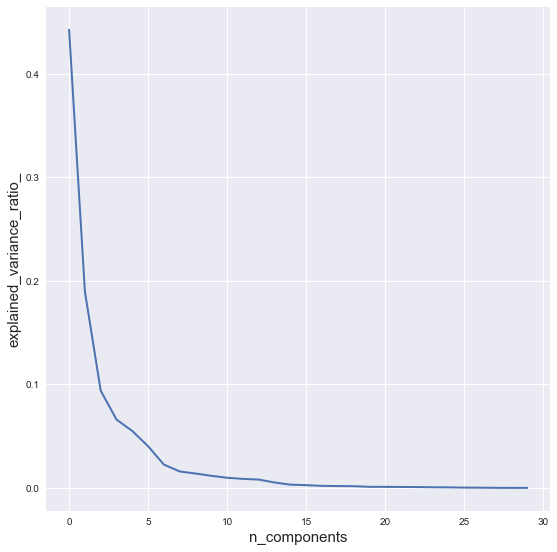

In [143]:
aaa =plt.figure(1, figsize=(10, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

**PCA with 3 components **

In [144]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [145]:
X_pca = pca.transform(X)

In [146]:
X_pca

array([[  9.19283683,   1.94858303,  -1.1231654 ],
       [  2.3878018 ,  -3.76817175,  -0.52929259],
       [  5.73389628,  -1.07517378,  -0.55174781],
       ..., 
       [  1.25617928,  -1.90229671,   0.56273047],
       [ 10.37479406,   1.67201008,  -1.87702879],
       [ -5.4752433 ,  -0.67063685,   1.49044426]])

In [147]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_pca, y,
                                                    stratify=y, 
                                                    test_size=0.2,random_state=201)

In [148]:
clf_rf = RandomForestClassifier()      

rf_pca = clf_rf.fit(X_train1, y_train1)

In [149]:
accuracy_score(y_test1,rf_pca.predict(X_test1))

0.92105263157894735

Populating the interactive namespace from numpy and matplotlib


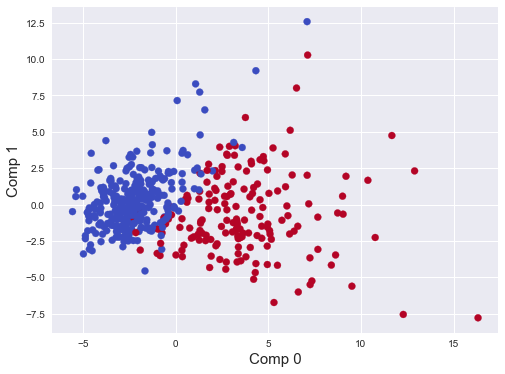

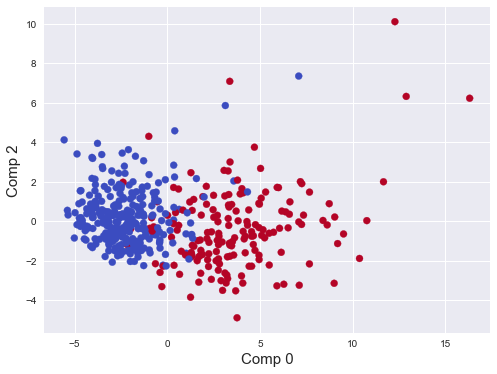

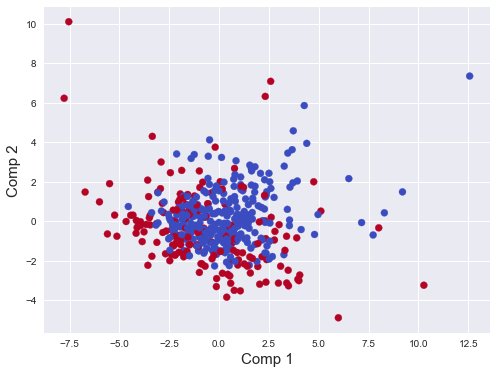

In [150]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
fig = plt.figure(1, figsize=(8, 6))
plt.scatter(X_train1[:, 0], X_train1[:, 1], c=pd.get_dummies(y_train1)["M"], cmap=plt.cm.coolwarm)  
plt.xlabel('Comp 0')
plt.ylabel('Comp 1')
plt.show()

fig = plt.figure(1, figsize=(8, 6))
plt.scatter(X_train1[:, 0], X_train1[:, 2], c=pd.get_dummies(y_train1)["M"], cmap=plt.cm.coolwarm)  
plt.xlabel('Comp 0')
plt.ylabel('Comp 2')
plt.show()

fig = plt.figure(1, figsize=(8, 6))
plt.scatter(X_train1[:, 1], X_train1[:, 2], c=pd.get_dummies(y_train1)["M"], cmap=plt.cm.coolwarm)  
plt.xlabel('Comp 1')
plt.ylabel('Comp 2')

plt.show()

Populating the interactive namespace from numpy and matplotlib


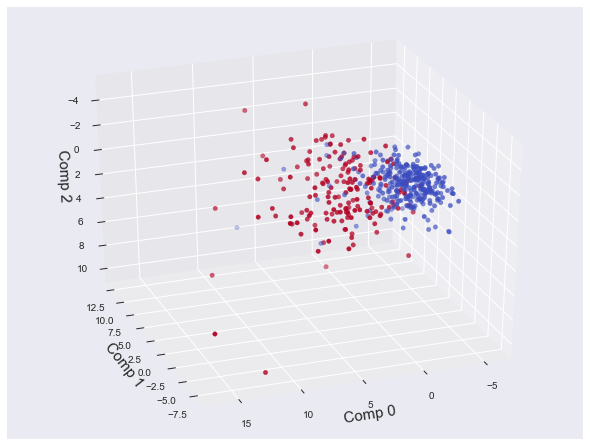

In [152]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.set_xlabel('Comp 0')
ax.set_ylabel('Comp 1')
ax.set_zlabel('Comp 2')
ax.scatter(X_train1[:, 0], X_train1[:, 1], X_train1[:, 2], c=pd.get_dummies(y_train1)["M"],cmap=plt.cm.coolwarm)
plt.show()

# <a id="p7">Conclusions</a>

> **We can predict the diagnosis with an accuracy of 94.7%**

> **We determined the most relevant features for diagnosis prediction:**
- radius_mean (malignant cancer cells are bigger in average)
- radius_se (the variance of radius values is larger)
- concavity_mean (severity of concave portions of the contour)

> **To improve the accuracy of the predictions we would need to collect more data**